In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [3]:
from matplotlib import animation
plt.rcParams['animation.html'] = 'html5'

def create_anim(fname, skip):
    with Dataset(fname, "r") as df:
        ETA = df.variables['eta'][:,:,:]
        x = df.variables['x'][:]
        y = df.variables['y'][:]
    print 'done loading...'


    ETA = ETA[::skip,:,:]
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlim((x.min(), x.max()))
    ax.set_ylim((y.min(), y.max()))
    im = ax.pcolor(x, y, ETA[0], animated=True, vmin=-0.1, vmax=0.1)
    p1, = ax.plot(x[(50,150,150,50),(50,50,150,150)], y[(50,150,150,50),(50,50,150,150)],'o', color='black')
    plt.colorbar(im)
    # animation function. This is called sequentially
    def animate(i):
        im.set_array(ETA[i, :-1, :-1].flatten())
        p1.set_data(x[(50,150,150,50),(50,50,150,150)], y[(50,150,150,50),(50,50,150,150)])
        return im, p1
    # call the animator. blit=True means only re-draw the parts that have changed.
    return animation.FuncAnimation(fig, animate, frames=ETA.shape[0], interval=20, blit=True)

# Yanai waves

Equatorial waves have solutions in the form of Hermite polynomials.
Functions of meridonial velocity:

$$ v(y) = H_n(y) \exp{\frac{-y^2}{2}}  $$

$$ H_0 = 1 $$
$$ H_1 = 2y $$ 
$$ H_2 = 4y^2 - 2 $$

In [163]:
y = np.arange(-4, 4.1, 0.1)
gauss = np.exp(-y**2/2.)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(y, gauss, label="n=0")
ax1.plot(y, 2*y*gauss, label="n=1")
ax1.plot(y, (4*y**2 - 2)*gauss/2., label="n=2")
ax1.set_xlabel("Latitude")
ax1.set_ylabel("Meridional Velocity")
ax1.set_title("Meridional wave velocity")
ax1.set_xlim(-4,4)
ax1.legend()

k = w = y
beta = 1
c = w/k

def poincare(k, n, beta=1, c=1):
    return np.sqrt(c**2*k**2 + (2*n+1)*beta*c)

def rossby(k, n, beta=1, c=1):
    return -beta*k/(k**2 + (2*n+1)*beta/c)

yanai = k*c/2. + np.sqrt(k**2*c**2/4. + beta*c)

ax2.plot(k[40:], w[40:])
ax2.plot(k, poincare(k, 1), label="Poincare, n=1")
ax2.plot(k, poincare(k, 2), label="Poincare, n=2")
ax2.plot(k, yanai, label="Yanai, n=0")
ax2.plot(k[:41], rossby(k[:41], 1), label="Rossby, n=1")
ax2.plot(k[:41], rossby(k[:41], 2), label="Rossby, n=2")
ax2.plot([0,0],[-1,5], '--', color='black')
ax2.set_xlabel(r"Wavenumber $k \sqrt{c/\beta}$")
ax2.set_ylabel(r"Frequency $\omega/ \sqrt{\beta c}$")
ax2.set_title("Disperison relations for EQ waves")
ax2.set_ylim(0, 5)
ax2.set_xlim(-4, 4)
ax2.legend()

plt.savefig("latex/wavevel_dispersionrel.eps")
plt.show()

In [5]:
def hofmoeller(fname, latidx):
    with Dataset(fname, 'r') as df:
        eta = df['eta'][:,latidx,:]
        x = df['x'][:]
        dt = df.getncattr("saved_timestep")
        y = df['y'][latidx,0]
    x = x[0]
    time = np.arange(0, eta.shape[0]*dt, dt)
    x, time = np.meshgrid(x, time)
    return y, x, time, eta

In [5]:
with Dataset("yanai_poincare.nc") as df:
    eta = df['eta'][0, :, :]
    x = df['x'][:]
    y = df['y'][:]
    g = df.getncattr("g")
    H = df.getncattr("H")
    beta = 1e-11
    c0 = np.sqrt(g*H)
    cR = c0/3.
    cY = np.sqrt(c0**2/4 + beta/c0)
    print "Gravity wave speed:", c0
    print "Rossby wave speed: ", cR
    print "Yanai wave speed:  ", cY

plt.pcolormesh(x/1000, y/1000, eta)
plt.colorbar()
plt.xlabel("X-Position [m]")
plt.ylabel("Y-Position [m]")
plt.title("SSH inital condition")
plt.savefig('latex/yanai_init.eps', dpi=200)
plt.show()

Gravity wave speed: 2.0
Rossby wave speed:  0.666666666667
Yanai wave speed:   1.0


In [13]:
import matplotlib.ticker as mtick

y, x, time, eta = hofmoeller("rossby_poincare.nc", 120)
i = 4000
skip = 50

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
im = ax1.pcolormesh(x[:i:skip], time[:i:skip], eta[:i:skip], vmin=-0.1, vmax=0.3)
ax1.set_xlabel("X-Position [m]")
ax1.set_ylabel("Time [s]")
ax1.set_title("Hoffmoeller diagram at Y = {}m".format(y))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
plt.colorbar(im, ax=ax1)

y, x, time, eta = hofmoeller("rossby_poincare.nc", 80)
im = ax2.pcolormesh(x[:i:skip], time[:i:skip], eta[:i:skip], vmin=-0.1, vmax=0.3)
ax2.set_xlabel("X-Position [m]")
ax2.set_ylabel("Time [s]")
ax2.set_title("Hoffmoeller diagram at Y = {}m".format(y))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
plt.colorbar(im, ax=ax2)


x0 = 4.8e6; x1 = 2.0e6; t0 = 0; t1 = time[:i:skip][-1,-1]
c = (x1-x0)/(t1-t0)
ax2.plot([x0,x1],[t0,t1], color='black', label="Rossby wave; c = {:1.2f} m/s".format(c))
ax1.plot([x0,x1],[t0,t1], color='black', label="Rossby wave; c = {:1.2f} m/s".format(c))
print "rossby wave speed:  ", c

x0 = 0.; x1 = 5.9e6; t0 = 3e6; t1 = 5.8e6
c = (x1-x0)/(t1-t0)
ax2.plot([x0,x1],[t0,t1], "--", color='black', label="Poincare wave; c = {:1.2f} m/s".format(c))
ax1.plot([x0,x1],[t0,t1], "--", color='black', label="Poincare wave; c = {:1.2f} m/s".format(c))
print 'gravity wave speed:', c

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.savefig('latex/rossby_hofmoeller.pdf')
plt.show()

rossby wave speed:   -0.472573839662
gravity wave speed: 2.10714285714


KeyboardInterrupt: 

yanai wave speed:   -0.354430379747
gravity wave speed: 2.10714285714


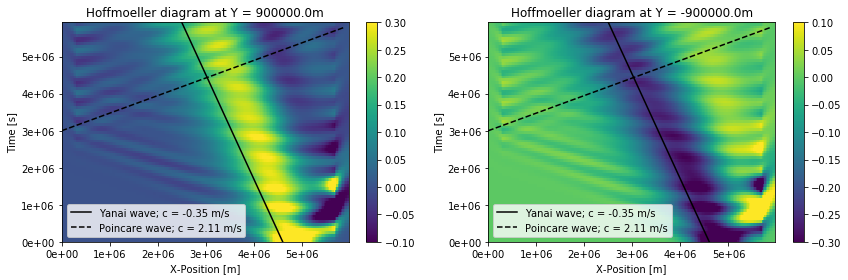

In [8]:
import matplotlib.ticker as mtick

y, x, time, eta = hofmoeller("yanai_poincare.nc", 130)
i = 4000
skip = 50

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
im = ax1.pcolormesh(x[:i:skip], time[:i:skip], eta[:i:skip], vmin=-0.1, vmax=0.3)
ax1.set_xlabel("X-Position [m]")
ax1.set_ylabel("Time [s]")
ax1.set_title("Hoffmoeller diagram at Y = {}m".format(y))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
plt.colorbar(im, ax=ax1)

y, x, time, eta = hofmoeller("yanai_poincare.nc", 70)
im = ax2.pcolormesh(x[:i:skip], time[:i:skip], eta[:i:skip], vmin=-0.3, vmax=0.1)
ax2.set_xlabel("X-Position [m]")
ax2.set_ylabel("Time [s]")
ax2.set_title("Hoffmoeller diagram at Y = {}m".format(y))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
plt.colorbar(im, ax=ax2)


x0 = 4.6e6; x1 = 2.5e6; t0 = 0; t1 = time[:i:skip][-1,-1]
c = (x1-x0)/(t1-t0)
ax2.plot([x0,x1],[t0,t1], color='black', label="Yanai wave; c = {:1.2f} m/s".format(c))
ax1.plot([x0,x1],[t0,t1], color='black', label="Yanai wave; c = {:1.2f} m/s".format(c))
print "yanai wave speed:  ", c

x0 = 0.; x1 = 5.9e6; t0 = 3e6; t1 = 5.8e6
c = (x1-x0)/(t1-t0)
ax2.plot([x0,x1],[t0,t1], "--", color='black', label="Poincare wave; c = {:1.2f} m/s".format(c))
ax1.plot([x0,x1],[t0,t1], "--", color='black', label="Poincare wave; c = {:1.2f} m/s".format(c))
print 'gravity wave speed:', c

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.savefig('latex/yanai_hofmoeller.pdf')
plt.show()

# Frequency spetrum

Simulation setup
L  = 1e6
dx = 5e3

k  = 1e-4
f0 = 1e-5
beta = 1e-11


In [7]:
fname = "BottomFrictionSW_L1000000.0_dx5000.0.nc"
fname = "BottomFrictionSW_L4000000.0_dx20000.0.nc"
# fname = "centralblob_0.5dt.nc"

# fshort  = "centralblob_0.5dt_400x400.nc"
# fshort = flong

In [8]:
with Dataset(fname, "r") as df:
    i = 100
    eta = df['eta'][i,:,:]
    x   = df['x'][:]
    y   = df['y'][:]
x /= 1000
y /= 1000

In [11]:
plt.pcolormesh(x, y, eta, cmap='binary')
plt.plot(x[100,2], y[100,2], 'o', color="blue", label='W')
plt.plot(x[100,190], y[100,190], 'o', color="yellow", label="E")
plt.plot(x[150,100], y[150,100], 'o', color="green", label="N")
plt.plot(x[75,75], y[75,75], 'o', color="red", label="S")
plt.title("Mooring locations")
plt.xlabel("x-Location [km]")
plt.ylabel("y-Location [km]")
plt.legend()
plt.savefig("latex/locs.eps")
plt.show()

In [12]:
def get_eta_timeseries(fname, lat, lon):
    with Dataset(fname, "r") as df:
        eta = df['eta'][:, lat, lon]
        dt = df.getncattr('saved_timestep')
        time = np.arange(0., dt*eta.shape[0], dt)
    return dt, time, eta

In [13]:
def calc_fft(eta, dt):
    """Numpy's FFT"""
    N = eta.shape[0]
    dft = np.fft.fft(eta)
    dft = np.abs(dft[:N/2+1])
    freq = np.fft.fftfreq(N, d=dt)
    return freq[:N/2+1], dft

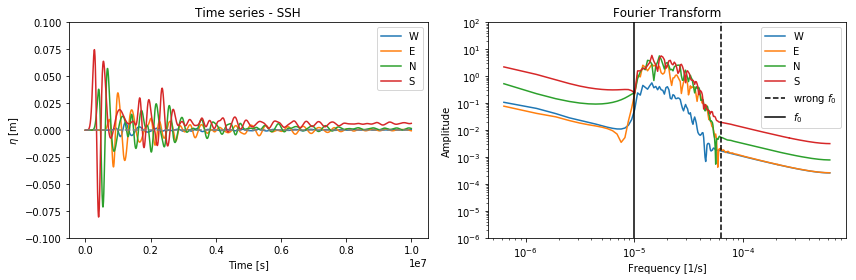

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

f0 = 1e-5 # rad/s
fE = f0*2*np.pi

coords = [[100,0,"W"], [100,15,"E"], [100,50,"N"], [75,75,"S"]]

# coords = [[50,50,"SW"]]
for lat, lon, lbl in coords:
    dt, time, eta = get_eta_timeseries(fname, lat, lon)
    ax1.plot(time, eta, label=lbl)

    freq, fft = calc_fft(eta, dt)
    ax2.plot(2*np.pi*freq, fft, label=lbl)

ax1.set_ylim(-0.1,0.1)
ax1.set_ylabel(r"$\eta$ [m]")
ax1.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel("Frequency [1/s]")   
y1 = 1e-6; y2 = 1e2
ax2.set_ylim(y1, y2)
ax1.set_title("Time series - SSH")    
ax2.set_title("Fourier Transform")
ax1.plot([0.,time[-1]], [0.,0.], '--', color='grey')
ax2.plot([fE, fE], [y1, y2],'--', color='black', label=r"wrong $f_0$")
ax2.plot([f0, f0], [y1, y2], color='black', label=r"$f_0$")
ax2.loglog()
ax2.legend()
ax1.legend()
plt.tight_layout()
plt.savefig("latex/ffts.eps")
plt.show()

# old

In [9]:
def get_eta_timeseries(fshort, flong, lat, lon):
    with Dataset(fshort, "r") as df:
        eta_short = df['eta'][:, lat, lon]
        dt_short = df.getncattr('saved_timestep')
        time_short = np.arange(0., dt_short*eta_short.shape[0], dt_short)

    with Dataset(flong, "r") as df:
        eta_long = df['eta'][:, lat, lon]
        dt_long = df.getncattr('saved_timestep')
        time_long = np.arange(0., dt_long*eta_long.shape[0], dt_long)
    return (dt_short, time_short, eta_short), (dt_long, time_long, eta_long)

0 50
190 50
50 50
75 75


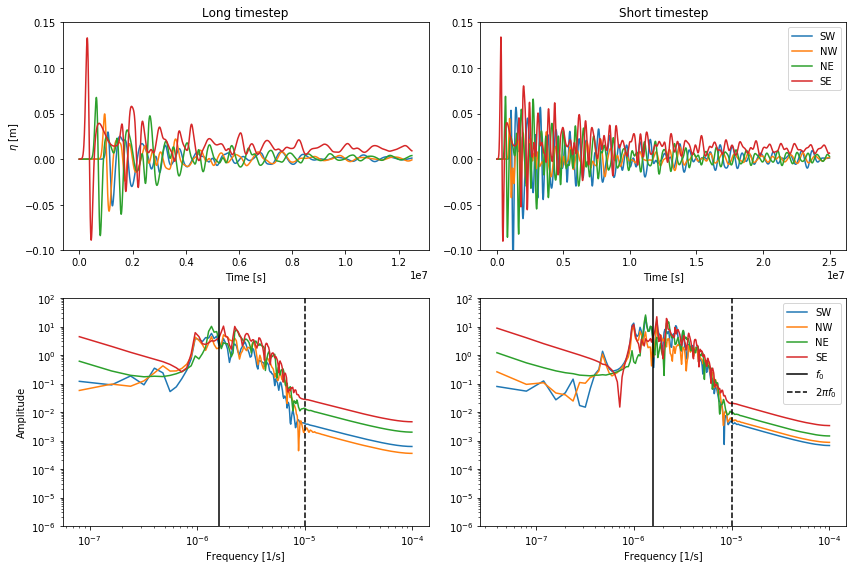

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

f0 = 1e-5 # rad/s 1/s???
fE = f0/(2*np.pi)

coords = [[0,50,"SW"], [190,50,"NW"], [50,50,"NE"], [75,75,"SE"]]
# coords_fine = [[100,100,"flongflongSW"], [300,100,"NW"], [300,300,"NE"], [100,300,"SE"]]

# coords = [[50,50,"SW"]]
for lat, lon, lbl in coords:
    (dt_short, time_short, eta_short), (dt_long, time_long, eta_long) = \
        get_eta_timeseries(fshort, flong, lat, lon)
    ax1.plot(time_long, eta_long, label=lbl)
    ax2.plot(time_short, eta_short, label=lbl)

    ax1.set_ylim(-0.1,0.15)
    ax1.set_ylabel(r"$\eta$ [m]")
    ax1.set_xlabel('Time [s]')
    ax2.set_ylim(-0.1,0.15)
    ax2.set_xlabel('Time [s]')
    ax2.set_title("Short timestep")
    ax1.set_title("Long timestep")

    freq_long, fft_long = calc_fft(eta_long, dt_long)
    freq_short, fft_short = calc_fft(eta_short, dt_short)
    ax3.plot(freq_long, fft_long, label=lbl)
    ax4.plot(freq_short, fft_short, label=lbl)
    ax3.set_ylabel('Amplitude')
    ax3.set_xlabel("Frequency [1/s]")   
    ax4.set_xlabel("Frequency [1/s]")
    y1 = 1e-6; y2 = 1e2
    ax4.set_ylim(y1, y2)
    ax3.set_ylim(y1, y2)
    print lat, lon

ax1.plot([0.,time_short[-1]], [0.,0.], color='black')
ax3.plot([fE, fE], [y1, y2], color='black')
ax4.plot([fE, fE], [y1, y2], color='black', label=r"$f_0$")
ax3.plot([fE*(2*np.pi), fE*(2*np.pi)], [y1, y2], '--', color='black')
ax4.plot([fE*(2*np.pi), fE*(2*np.pi)], [y1, y2], '--', color='black', label=r"$2 \pi f_0$")
ax3.loglog()
ax4.loglog()
ax2.legend()
ax4.legend()
plt.tight_layout()
plt.savefig("latex/ffts.eps")
plt.show()

In [111]:
create_anim(flong, skip=10)

NameError: name 'create_anim' is not defined

In [6]:
with Dataset(fshort, "r") as df:
    ETA = df.variables['eta'][:,:,:]
    x = df.variables['x'][:]
    y = df.variables['y'][:]
print 'done loading...'


ETA = ETA[::50,:,:]
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.gca()
ax.set_xlim((x.min(), x.max()))
ax.set_ylim((y.min(), y.max()))
im = ax.pcolor(x, y, ETA[0], animated=True, vmin=-0.1, vmax=0.1)
p1, = ax.plot(x[(50,150,150,50),(50,50,150,150)], y[(50,150,150,50),(50,50,150,150)],'o', color='black')
plt.colorbar(im)
# animation function. This is called sequentially
def animate(i):
    im.set_array(ETA[i, :-1, :-1].flatten())
    p1.set_data(x[(50,150,150,50),(50,50,150,150)], y[(50,150,150,50),(50,50,150,150)])
    return im, p1
# call the animator. blit=True means only re-draw the parts that have changed.
animation.FuncAnimation(fig, animate, frames=ETA.shape[0], interval=20, blit=True)

done loading...
